In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import math
from IPython.display import display
from IPython import get_ipython

In [ ]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
TICKER="AAPL"
START_DATE="2018-01-01"
END_DATE="2023-12-3"
INPUT_SIZE=1
HIDDEN_SIZE=64
NUM_LAYERS=2
OUTPUT_SIZE=1
SEQ_LENGTH=60
LEARNING_RATE=0.001
NUM_EPOCHS=50
TEST_SIZE=0.2

In [ ]:
print(f"Downloading {TICKER} data...")
stock_data=yf.download(TICKER,start=START_DATE,end=END_DATE)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [ ]:
close_prices=stock_data[["Close"]].copy()
print("Data Downloaded")
print(close_prices.head())
print(f"\nTotal data points:{len(close_prices)}")

Data Downloaded
Price           Close
Ticker           AAPL
Date                 
2018-01-02  40.426823
2018-01-03  40.419792
2018-01-04  40.607529
2018-01-05  41.069859
2018-01-08  40.917313

Total data points:1490


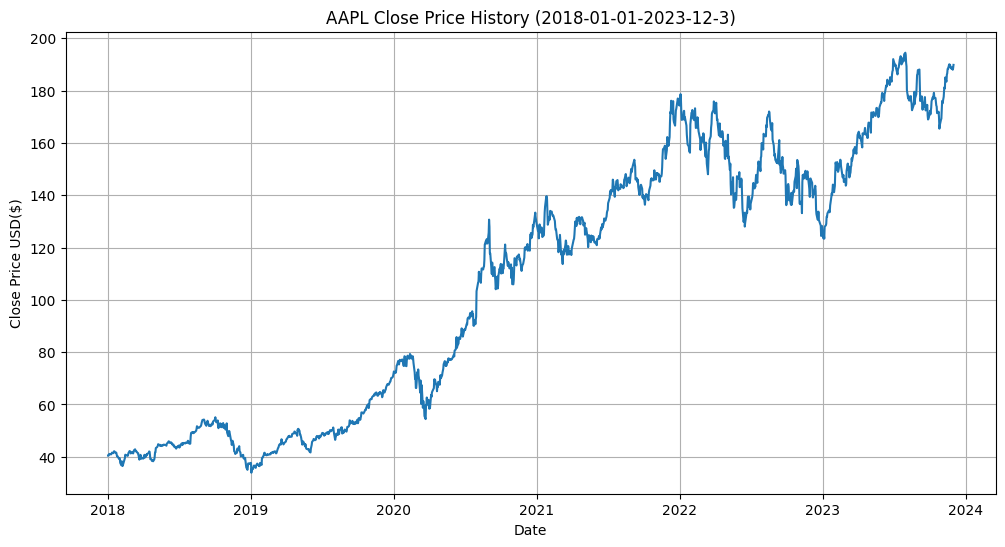

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(close_prices)
plt.title(f"{TICKER} Close Price History ({START_DATE}-{END_DATE})")
plt.xlabel("Date")
plt.ylabel("Close Price USD($)")
plt.grid(True)
plt.show()

In [ ]:
scaler=MinMaxScaler(feature_range=(-1,1))
scaled_data=scaler.fit_transform(close_prices)


In [ ]:
def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(x), np.array(y)

In [ ]:
x,y=create_sequences(scaled_data,SEQ_LENGTH)
print(f"\n Shape of sequences(x):{x.shape}")
print(f"\n Shape of targets(y):{y.shape}")


 Shape of sequences(x):(1430, 60, 1)

 Shape of targets(y):(1430, 1)


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=TEST_SIZE, random_state=42, shuffle=False)

print(f"\n Shape of x_train:{x_train.shape}")
print(f"\n Shape of y_train:{y_train.shape}")
print(f"\n Shape of x_test:{x_test.shape}")
print(f"\n Shape of y_test:{y_test.shape}")

x_train=torch.from_numpy(x_train).float().to(device)
y_train=torch.from_numpy(y_train).float().to(device)
x_test=torch.from_numpy(x_test).float().to(device)
y_test=torch.from_numpy(y_test).float().to(device)


 Shape of x_train:(1144, 60, 1)

 Shape of y_train:(1144, 1)

 Shape of x_test:(286, 60, 1)

 Shape of y_test:(286, 1)


In [ ]:
class StockLSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, output_size):
    super(StockLSTM, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.fc=nn.Linear(hidden_size,output_size)
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
  def forward(self, x):
    h0 = torch.zeros(self.num_layers,x.size(0),self.hidden_size).to(device)
    c0 = torch.zeros(self.num_layers,x.size(0),self.hidden_size).to(device)
    out, _ = self.lstm(x,(h0,c0))
    out = out[:, -1, :]
    out = self.fc(out)
    return out

In [ ]:
model=StockLSTM(INPUT_SIZE,HIDDEN_SIZE,NUM_LAYERS,OUTPUT_SIZE).to(device)
print("\n Model Architecture:")
print(model)


 Model Architecture:
StockLSTM(
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
)


In [ ]:
criterian=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=LEARNING_RATE)

In [ ]:
print("\Starting Training..")
train_losses=[]
for epoch in range(NUM_EPOCHS):
  model.train()
  outputs=model(x_train)
  loss=criterian(outputs,y_train)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  train_losses.append(loss.item())

  if (epoch+1)%10==0:
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Loss:{loss.item():.6f}")
print("Training Finished.")

\Starting Training..
Epoch [10/50], Loss:0.270494
Epoch [20/50], Loss:0.120173
Epoch [30/50], Loss:0.019105
Epoch [40/50], Loss:0.011172
Epoch [50/50], Loss:0.007072
Training Finished.


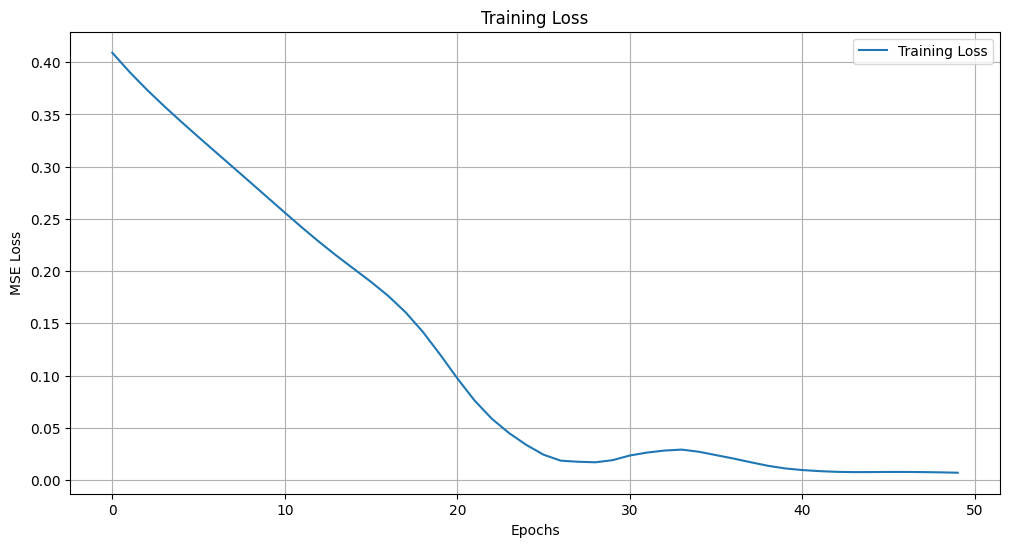

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(train_losses,label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("Training Loss")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model.eval()
with torch.no_grad():
  test_predictions_scaled=model(x_test)


In [ ]:
train_size = len(x_train)
test_predictions=scaler.inverse_transform(test_predictions_scaled.cpu().numpy())
y_test_actual=scaler.inverse_transform(y_test.cpu().numpy())

In [ ]:
rmse=math.sqrt(mean_squared_error(y_test_actual,test_predictions))
print(f"\n Root Mean Squared Error (RMSE):{rmse:.2f}")


 Root Mean Squared Error (RMSE):17.07


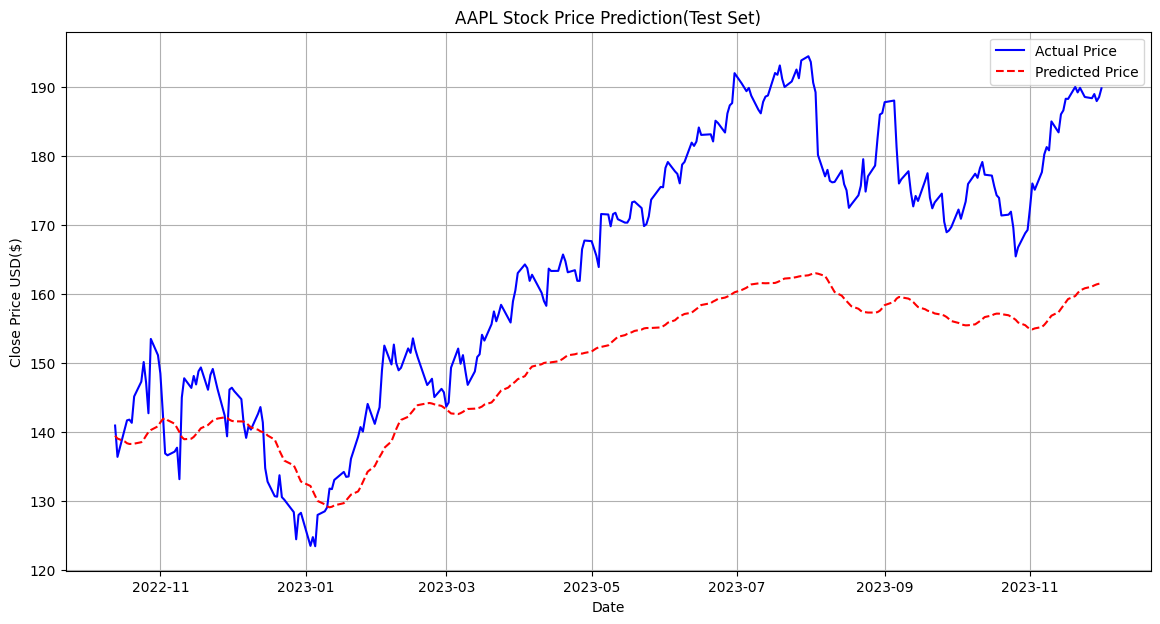

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(stock_data.index[train_size+SEQ_LENGTH:],y_test_actual,label="Actual Price",color="blue")
plt.plot(stock_data.index[train_size+SEQ_LENGTH:],test_predictions,label="Predicted Price",color="red",linestyle="--")
plt.xlabel("Date")
plt.ylabel("Close Price USD($)")
plt.title(f"{TICKER} Stock Price Prediction(Test Set)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print("\n Predicting the next day's price...........")
last_sequence_scaled=scaled_data[-SEQ_LENGTH:]
last_sequence_scaled=torch.tensor(last_sequence_scaled).float().unsqueeze(0).to(device)
model.eval()
with torch.no_grad():
    next_day_prediction_scaled=model(last_sequence_scaled)
next_day_prediction=scaler.inverse_transform(next_day_prediction_scaled.cpu().numpy())
print(f"\nScaled input sequence: {last_sequence_scaled.shape}")
print(f"\n Predicted Scaled Value for the next day:{next_day_prediction_scaled.item():.6f}")
print(f"\n Predicted close price for next day:${next_day_prediction[0][0]:.2f}")


 Predicting the next day's price...........

Scaled input sequence: torch.Size([1, 60, 1])

 Predicted Scaled Value for the next day:0.591049

 Predicted close price for next day:$161.66


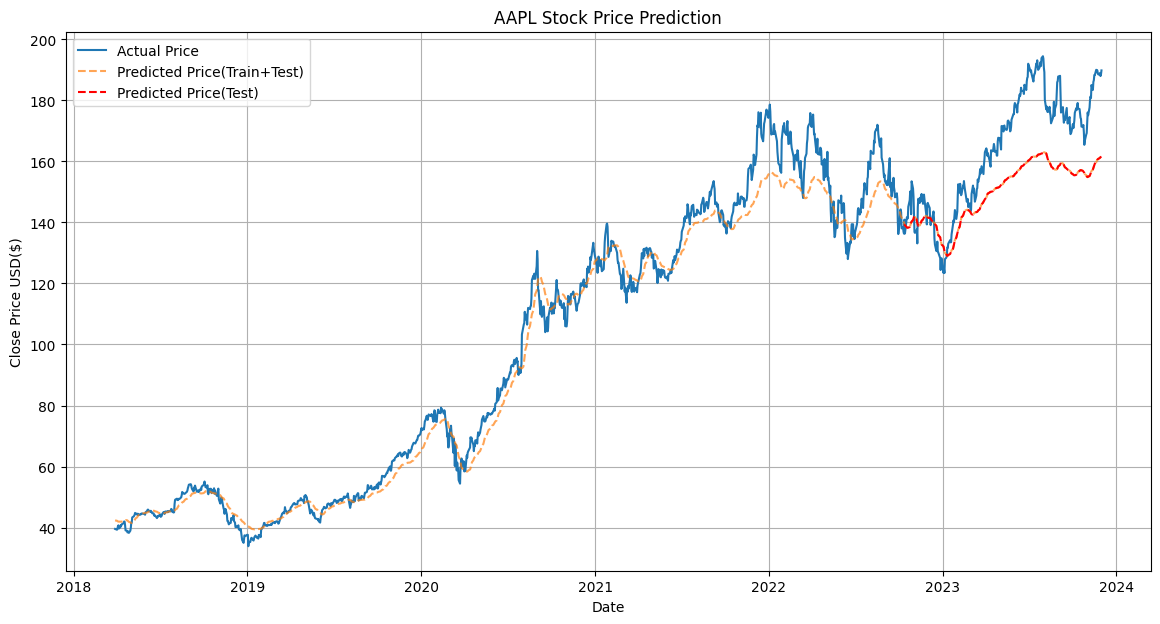

In [ ]:
all_predictions_scaled=[]
model.eval()
with torch.no_grad():
    train_predictions_scaled=model(x_train)
    all_predictions_scaled.extend(train_predictions_scaled.cpu().numpy())
    all_predictions_scaled.extend(test_predictions_scaled.cpu().numpy())
all_predictions=scaler.inverse_transform(np.array(all_predictions_scaled))
plot_df=pd.DataFrame(index=close_prices.index[SEQ_LENGTH:])
plot_df["Actual"]=close_prices[SEQ_LENGTH:]
plot_df["Predicted"]=all_predictions

plt.figure(figsize=(14,7))
plt.plot(plot_df["Actual"],label="Actual Price")
plt.plot(plot_df["Predicted"],label="Predicted Price(Train+Test)",alpha=0.7,linestyle="--")
test_start_index=plot_df.index[len(train_predictions_scaled)]
# Corrected the line to access the 'Predicted' column using square brackets
plt.plot(plot_df.loc[test_start_index:].index,plot_df["Predicted"].loc[test_start_index:],color='red',linestyle="--",label="Predicted Price(Test)")
plt.xlabel("Date")
plt.ylabel("Close Price USD($)")
plt.title(f"{TICKER} Stock Price Prediction")
plt.legend()
plt.grid(True)
plt.show()